**Monte Carlo Constant alpha Control Method**

In [4]:
import sys
import gym
import numpy as np
from collections import defaultdict

In [8]:
num_episodes = 1000000
epsilon_start = 1.0
epsilon_decay = .9999965
epsilon_min = 0.05

epsilon = epsilon_start

for episode in range(num_episodes):
    epsilon = max(epsilon*epsilon_decay, epsilon_min)
    if episode % 100000 == 0:
        print(f"Episode: {episode} -> epsilon={epsilon}")



Episode: 0 -> epsilon=0.9999965
Episode: 100000 -> epsilon=0.7046851916863968
Episode: 200000 -> epsilon=0.4965829574224525
Episode: 300000 -> epsilon=0.3499358813150294
Episode: 400000 -> epsilon=0.24659549668667013
Episode: 500000 -> epsilon=0.17377280305645773
Episode: 600000 -> epsilon=0.12245554962615056
Episode: 700000 -> epsilon=0.08629291448656881
Episode: 800000 -> epsilon=0.060809551819579116
Episode: 900000 -> epsilon=0.05


In [50]:
environment = gym.make('Blackjack-v1')

def get_probability_for_action(Q_s, epsilon, num_of_actions):
    # 1 - epsilon + (epsilon/total_actions) for action having max action-value-function
    # epsilon / total_actions for others
    policy_state = np.ones(num_of_actions) * (epsilon / num_of_actions)
    max_action = np.argmax(Q_s)
    policy_state[max_action] = 1 - epsilon + (epsilon/num_of_actions)
    return policy_state

def generate_episode_from_Q(environment: gym.Env, Q : defaultdict, epsilon: float, num_of_actions: int):
    state = environment.reset()
    episode = []
    while True:
        probs = get_probability_for_action(Q, epsilon, num_of_actions)
        action = np.random.choice(np.arange(num_of_actions), p= probs) if state in Q else environment.action_space.sample()
        next_state,reward, is_done, _ = environment.step(action)

        episode.append( (state,action,reward) )
        if is_done:
            break
        state = next_state
    return episode

def update_action_value_table(environment: gym.Env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)

    discounts = np.array([gamma**i for i in range( len(rewards) + 1)])

    for i, state in enumerate(states):
        action, reward = actions[i], rewards[i]

        old_Q = Q[state][action]
        discounted_return = np.dot(rewards[i:], discounts[: -(i+1)])
        Q[state][action] = old_Q + alpha*(discounted_return - old_Q)
    return Q

In [59]:
num_episodes = 500000

def monte_carlo_temporal_difference(env, num_episodes,  epsilon_decay, alpha = 0.2, gamma = 0.8):
    epsilon_start = 1.0
    #epsilon_decay = .9999965
    epsilon_min = 0.05
    epsilon = epsilon_start

    num_of_actions = environment.action_space.n
    Q = defaultdict(lambda : np.zeros(num_of_actions))

    for episode_counter in range(1, num_episodes+1):
        epsilon = max(epsilon*epsilon_decay, epsilon_min)
        if episode_counter % 100000 == 0:
            print(f"Episode: {episode_counter} -> epsilon={epsilon}")
        episode = generate_episode_from_Q(environment, Q, epsilon, num_of_actions)
        Q = update_action_value_table(environment, episode,Q,alpha,gamma)
    policy = dict((state,np.argmax(actions)) for state, actions in Q.items())
    return policy, Q

In [60]:
num_episodes=1000000
alpha = 0.02
eps_decay=.9999965 
gamma=1.0

policy, Q = monte_carlo_temporal_difference(environment, num_episodes, eps_decay,alpha,gamma)

Episode: 100000 -> epsilon=0.7046876580932001
Episode: 200000 -> epsilon=0.49658469546888667
Episode: 300000 -> epsilon=0.34993710609490075
Episode: 400000 -> epsilon=0.24659635977392935
Episode: 500000 -> epsilon=0.17377341126339715
Episode: 600000 -> epsilon=0.12245597822207434
Episode: 700000 -> epsilon=0.0862932165128266
Episode: 800000 -> epsilon=0.060809764653755406
Episode: 900000 -> epsilon=0.05
Episode: 1000000 -> epsilon=0.05


In [63]:
#source: https://github.com/udacity/deep-reinforcement-learning/blob/master/monte-carlo/plot_utils.py

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

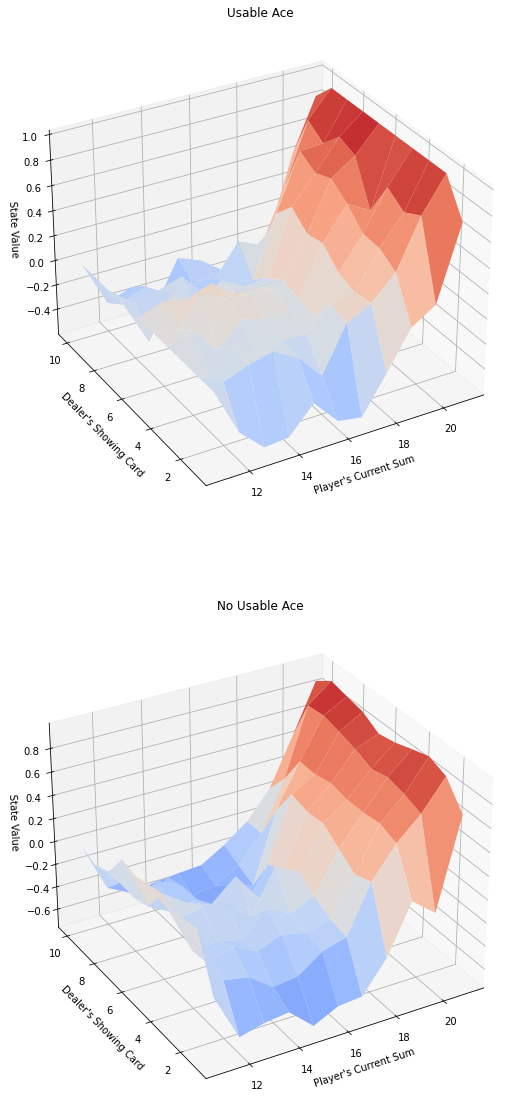

In [62]:
V = dict((state,np.max(actions)) for state, actions in Q.items())

plot_blackjack_values(V)